<a href="https://colab.research.google.com/github/fMurugi/content-moderation-cohere-ai-app/blob/master/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import cv2
from PIL import Image

In [20]:
mean_gray = 0.1307
stddev_gray = 0.3081

tranforms = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((mean_gray),(stddev_gray))])
train_dataset = datasets.MNIST(root='./data',train=True,transform=tranforms,download=True)
test_dataset = datasets.MNIST(root='./data',train=False,transform=tranforms)

tranforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((mean_gray),(stddev_gray))])

Visualize  images

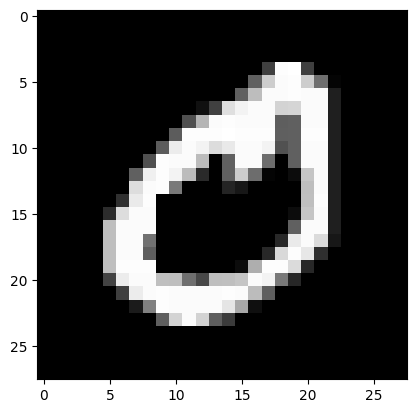

In [3]:
import matplotlib.pyplot as plt
randomn_img = train_dataset[21][0].numpy() *stddev_gray + mean_gray
randomn_img = randomn_img.reshape(28,28)
plt.imshow(randomn_img,cmap='gray')


create the data loader

In [4]:
batch_size =100
train_load = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_load = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

CREATE THE CNN


*   same padding means input _size  == output size




In [5]:
class CNN(nn.Module):
  def __init__(self):
      super(CNN,self).__init__()
      #
      #same padding formulat = (filter_size -1) //2 -> (3-1)/2 =1
      self.cnn1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1)
      #output size of each of the 8 feature maps:
      # [(input_size - filter_size +2(padding))/stride+1]
      #batch norm
      self.batchnorm1 = nn.BatchNorm2d(8)
      self.relu = nn.ReLU()

      self.maxpool = nn.MaxPool2d(kernel_size=2)
      #the output size =28/2 = 14

      self.cnn2 = nn.Conv2d(in_channels=8,out_channels=32,kernel_size=5,stride=1,padding=2)
      #output sie of each of 32 feature map:
      #[(14-5 +2(2))/1 +1]  =14
      self.batchnorm2 = nn.BatchNorm2d(32)
      #output size = 14/2 =7 after max pooling
      #flatten 32 feature map ,where each feature map is of 7 by 7
      self.fc1 = nn.Linear(32*7*7,600)
      #apply dropout for regularizaiton between two  fc layers
      self.dropout = nn.Dropout(p=0.5)
      self.fc2 = nn.Linear(600,10) # input neurons is 600 and output neurons is 10

  def forward(self,x):
      out = self.cnn1(x)
      out = self.batchnorm1(out)
      out = self.relu(out)
      out = self.maxpool(out)
      out = self.cnn2(out)
      out = self.batchnorm2(out)
      out = self.relu(out)
      out = self.maxpool(out)

      #flatten the feature maps
      out = out.view(out.size(0),-1)

      #forward through the fully connected layer
      out = self.fc1(out)
      out = self.relu(out)
      out = self.dropout(out)
      out = self.fc2(out)
      return out




In [6]:
model = CNN()
CUDA= torch.cuda.is_available()
if CUDA:
  model =model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [7]:
#train the CNN
num_epochs =10
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0
    #set model to training model
    model.train()
    for i,(inputs,labels) in enumerate(train_load):
        if CUDA:
          inputs = inputs.cuda()
          labels = labels.cuda()
        #forward propagation
        outputs = model(inputs)
        #loss calc
        loss = loss_fn(outputs,labels)
        iter_loss += loss.item()

        #back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        iterations +=1
    train_loss.append(iter_loss/iterations)
    train_accuracy.append((100*correct/len(train_dataset)))

    # testing phase
    correct = 0
    iterations = 0
    iter_loss = 0.0
    model.eval()
    for i,(inputs,labels) in enumerate(test_load):
        if CUDA:
          inputs = inputs.cuda()
          labels = labels.cuda()
        outputs = model(inputs)
        iter_loss += loss_fn(outputs,labels).item()
        _, predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        iterations +=1

    test_loss.append(iter_loss/iterations)
    test_accuracy.append((100*correct/len(test_dataset)))

    print('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}'.format(epoch+1,num_epochs,train_loss[-1],train_accuracy[-1],test_loss[-1],test_accuracy[-1]))









Epoch 1/10, Training Loss: 0.880, Training Accuracy: 72.398, Testing Loss: 0.110, Testing Accuracy: 97.000
Epoch 2/10, Training Loss: 0.216, Training Accuracy: 93.173, Testing Loss: 0.063, Testing Accuracy: 98.110
Epoch 3/10, Training Loss: 0.129, Training Accuracy: 96.220, Testing Loss: 0.056, Testing Accuracy: 98.420
Epoch 4/10, Training Loss: 0.100, Training Accuracy: 97.155, Testing Loss: 0.046, Testing Accuracy: 98.630
Epoch 5/10, Training Loss: 0.084, Training Accuracy: 97.590, Testing Loss: 0.046, Testing Accuracy: 98.570
Epoch 6/10, Training Loss: 0.072, Training Accuracy: 97.925, Testing Loss: 0.041, Testing Accuracy: 98.610
Epoch 7/10, Training Loss: 0.069, Training Accuracy: 98.062, Testing Loss: 0.037, Testing Accuracy: 98.860
Epoch 8/10, Training Loss: 0.062, Training Accuracy: 98.225, Testing Loss: 0.034, Testing Accuracy: 98.880
Epoch 9/10, Training Loss: 0.058, Training Accuracy: 98.350, Testing Loss: 0.044, Testing Accuracy: 98.890
Epoch 10/10, Training Loss: 0.061, Tr

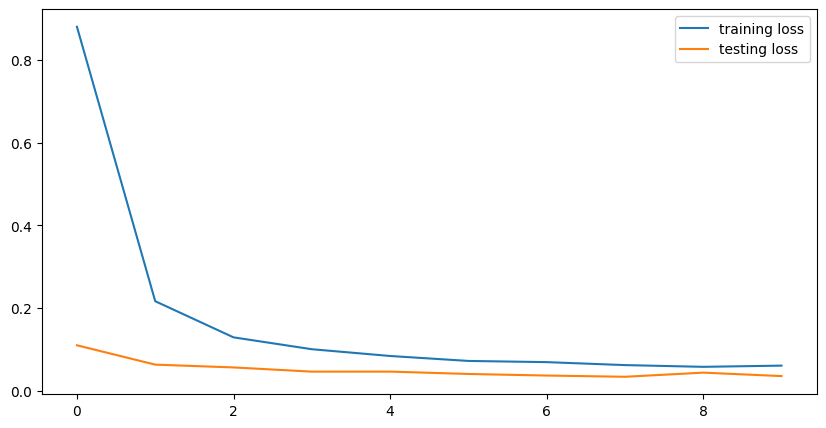

In [8]:
f = plt.figure(figsize=(10,5))
plt.plot(train_loss,label='training loss')
plt.plot(test_loss,label='testing loss')
plt.legend()
plt.show()

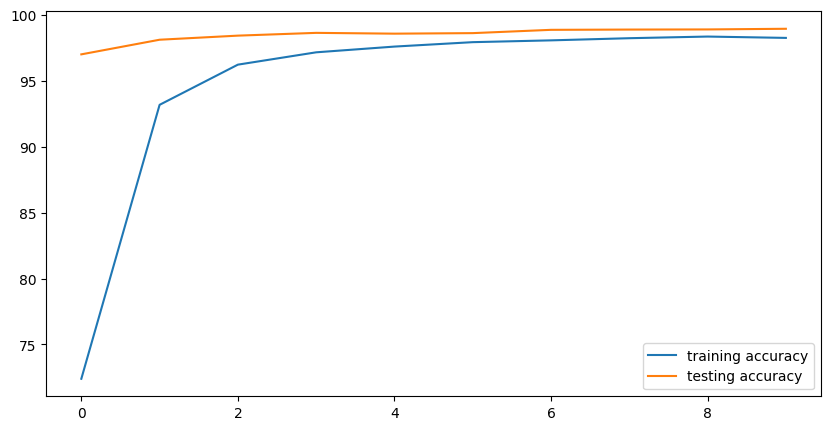

In [9]:
f = plt.figure(figsize=(10,5))
plt.plot(train_accuracy,label='training accuracy')
plt.plot(test_accuracy,label='testing accuracy')
plt.legend()
plt.show()

In [10]:
img = test_dataset[30][0].resize_((1,1,28,28))
label = test_dataset[30][1]

model.eval()
if CUDA:
  model = model.cuda()
  img = img.cuda()
output = model(img)
_,predicted = torch.max(output,1)
print(predicted,label)

tensor([3], device='cuda:0') 3


In [27]:
from google.colab.patches import cv2_imshow

In [48]:
def predict(img_name,model):
  image = cv2.imread(img_name,0) #0 tranforms the image to a zero
  cv2_imshow(image)
  # ret,thresholded = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
  # # cv2_imshow(thresholded)
     # Method 1: Use Otsu's thresholding (automatically finds best threshold)
  ret, thresholded = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  print("\nAfter Otsu thresholding:")
  cv2_imshow(thresholded)

  img = 255 - thresholded
  print("\nAfter inberting:")
  cv2_imshow(img)
  img = Image.fromarray(img)
  img = tranforms_photo(img)
  img = img.view(1,1,28,28)
  if CUDA:
    img = img.cuda()
  model.eval() #when testing, to not do things like drop out or batch normalization during prediction
  output = model(img)
  _,predicted = torch.max(output,1)
  return predicted.item()


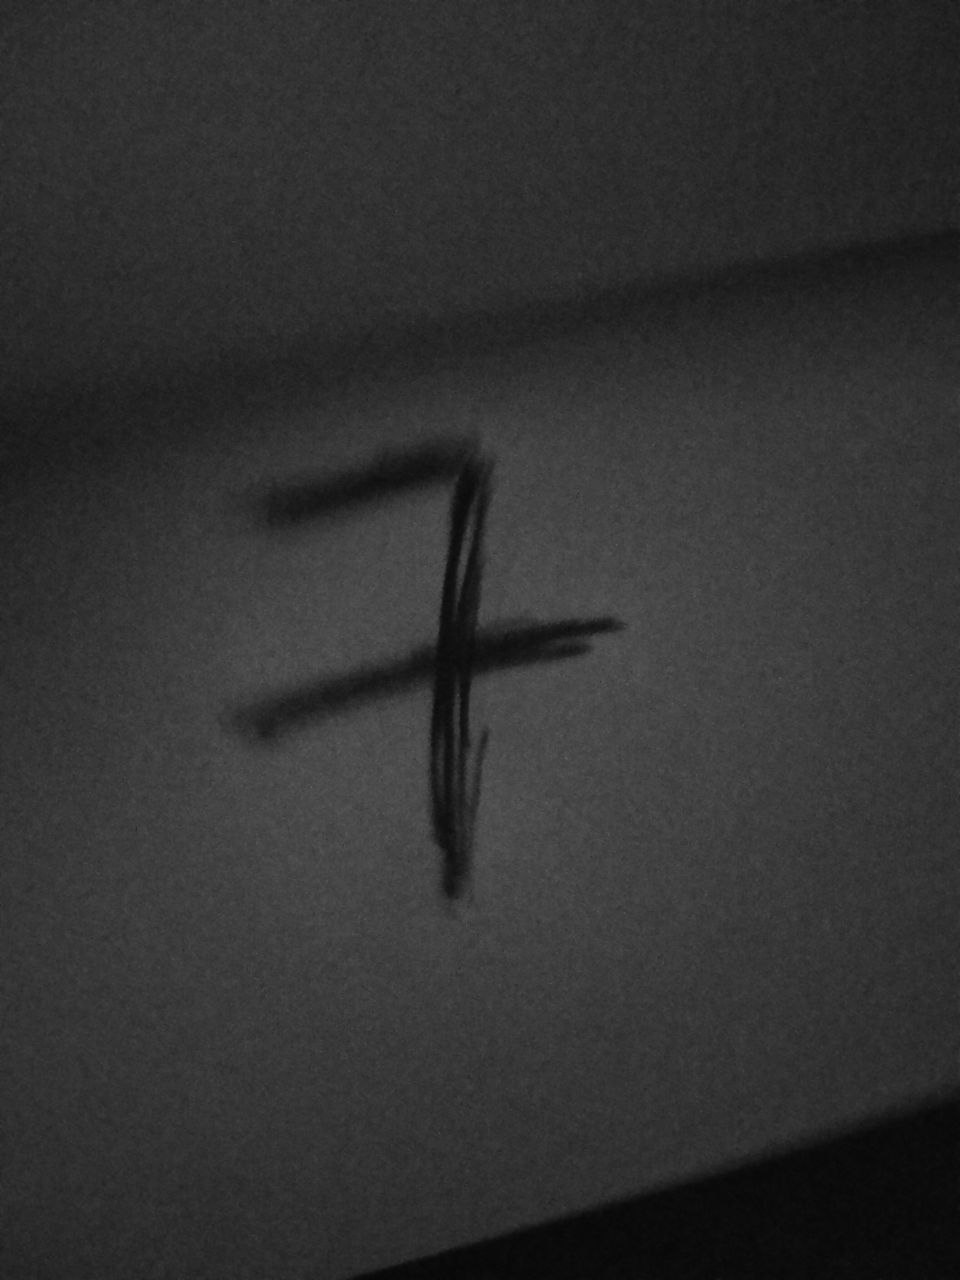


After Otsu thresholding:


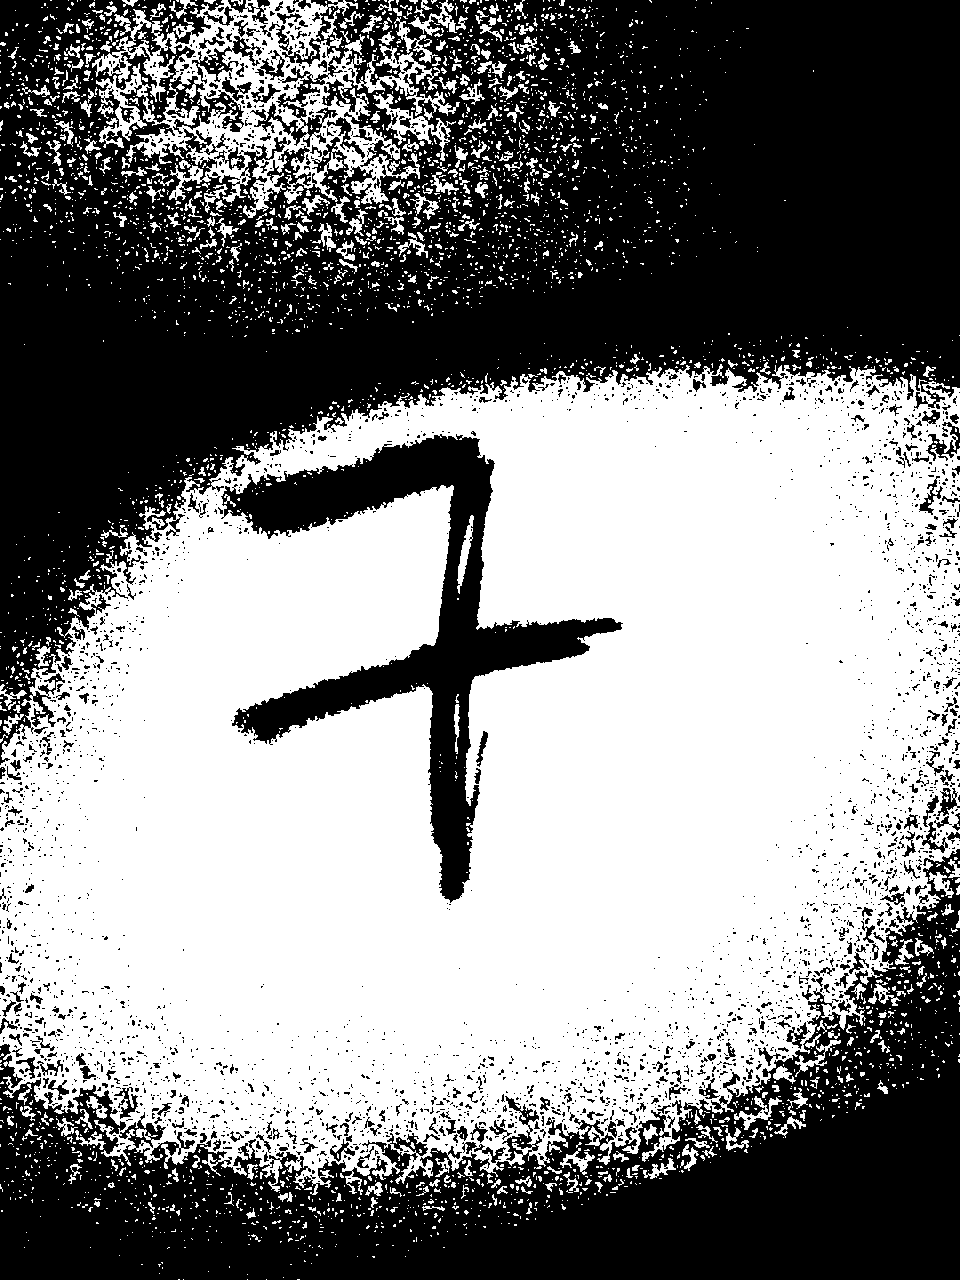


After inberting:


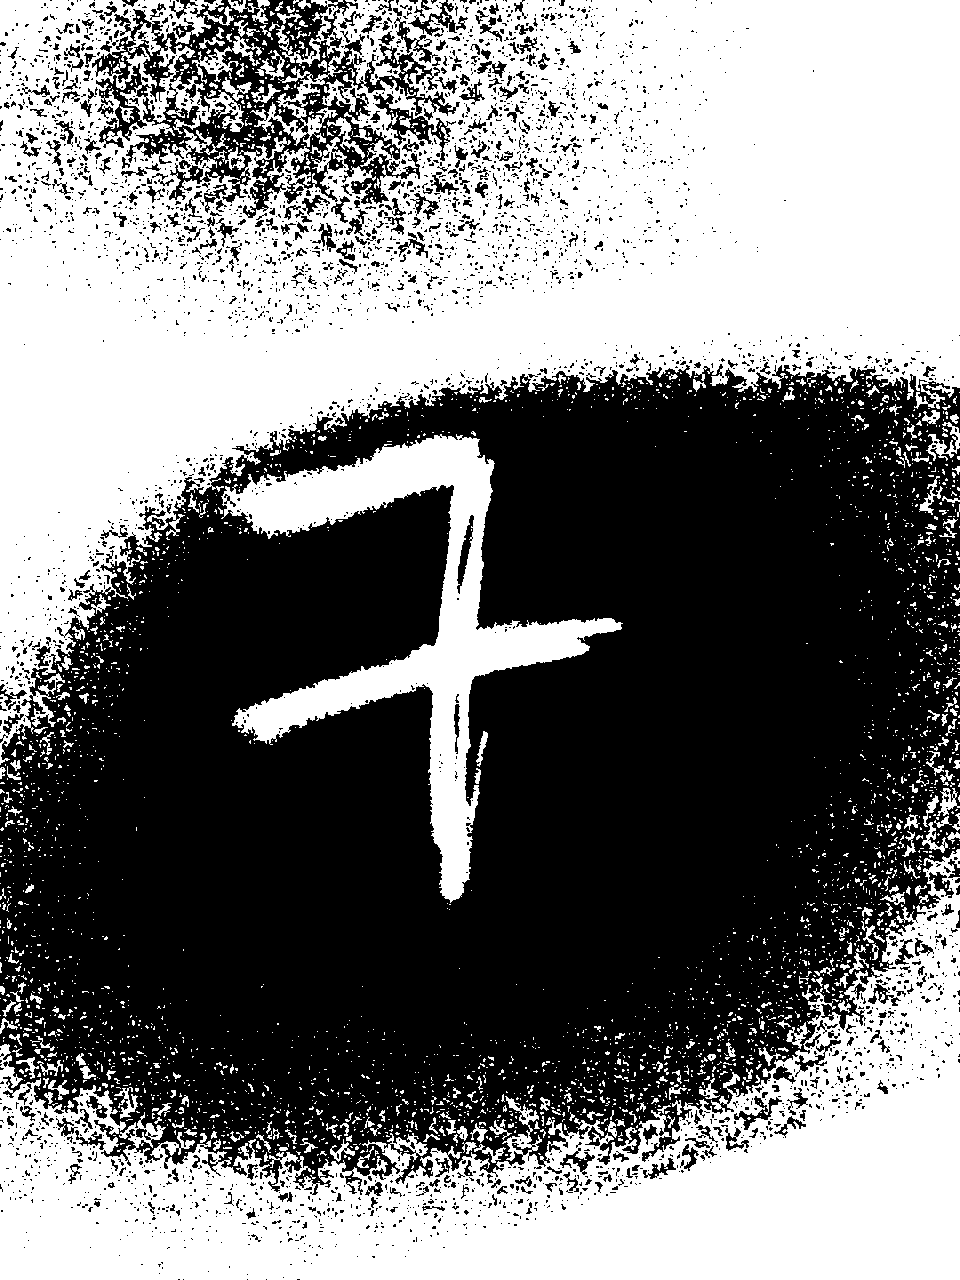

The Predicted Label is 5


In [49]:
pred = predict('seven.jpg', model)
print("The Predicted Label is {}".format(pred))